Summary: for data of FIFA World Cup from 1962 to 2022
* basic statistic
  * The total number of goals: 2142
  * The total number of matches: 752
  * The average number of goals in a match: 2.8484
  * Mean of time intervals between goals: 33.0589 min (don't connect two adjacent games)
  * Mean of time intervals between goals: 20.2072 min (connect two adjacent games)
* Poisson Process
  * The fit of exponential distribution
    * R^2 = 0.97616983 (don't connect two adjacent games)
    * R^2 = 0.97616972 (connect two adjacent games)

In [2]:
import numpy as np
import pandas as pd

# load data
df = pd.read_csv('../data/FIFA World Cup All Goals 1930-2022.csv', encoding='ISO-8859-1')

# only preserve data after 1962
start_row = 578
df_2 = df.iloc[start_row:,:]

# print some useful information
print("The total number of goals of FIFA World Cup from 1930 to 2022: ", df.shape[0])
print("The total number of goals of FIFA World Cup from 1962 to 2022: ", df_2.shape[0])

The total number of goals of FIFA World Cup from 1930 to 2022:  2720
The total number of goals of FIFA World Cup from 1962 to 2022:  2142


In [223]:
# get goal_time_str
n_goal = df_2.shape[0]
sub_str = "'"
goal_time_str = ['nan'] * n_goal
for i in range(start_row, start_row + n_goal):
    if sub_str in df_2.loc[i, 'minute_label']:
        goal_time_str[i - start_row] = df_2.loc[i, 'minute_label']
    else:
        goal_time_str[i - start_row] = df_2.loc[i, 'player_team_code']

In [224]:
# get goal_time from goal_time_str
import re
goal_time = np.zeros(n_goal)
is_stoppage = np.zeros(n_goal, dtype=bool)
is_stoppage_around_90 = np.zeros(n_goal, dtype=bool)
sub_str = "+"

for i in range(n_goal):
    if sub_str in goal_time_str[i]:
        parts = re.findall(r"\d+|'", goal_time_str[i])
        time_1 = np.fromstring(parts[0], dtype=int, sep=" ")
        time_2 = np.fromstring(parts[2], dtype=int, sep=" ")
        goal_time[i] = time_1 + time_2
        is_stoppage[i] = True
        if time_1 == 90:
            is_stoppage_around_90[i] = True
    else:
        parts = goal_time_str[i].split("'", 1)
        goal_time[i] = np.fromstring(parts[0], dtype=int, sep=" ")

goal_time= goal_time.astype(int)

# print some useful information
print("minimum of goal time:", np.min(goal_time), "min")
print("maximum of goal time:", np.max(goal_time), "min")
print("The total number of goals in the stoppage time:", sum(is_stoppage))
print("The total number of goals in the stoppage time around 90 minutes:", sum(is_stoppage_around_90))

minimum of goal time: 1 min
maximum of goal time: 121 min
The total number of goals in the stoppage time: 114
The total number of goals in the stoppage time around 90 minutes: 79


In [225]:
# get match_id
match_id = df_2.loc[:,'match_id']
n_match = match_id.nunique()

# print some useful information
print("The total number of matches:", n_match)
print("The average number of goals in a match: {:.4f}".format(n_goal/n_match))
print("ATTENTION: here we only take account matches with goals.")

The total number of matches: 752
The average number of goals in a match: 2.8484
ATTENTION: here we only take account matches with goals.


In [226]:
# calculate time intervals between goals
flag = "connect two adjacent games"
if flag == "don't connect two adjacent games":

    # use goal time and match id to calculate goal time interval
    goal_time_interval = np.zeros(n_goal)
    count = 0
    for i in range(1,n_goal): # start from the second, not the first
        if match_id.iloc[i] == match_id.iloc[i - 1]:        
            goal_time_interval[count] = goal_time[i] - goal_time[i - 1]
            count += 1

    # from float to int
    goal_time_interval = goal_time_interval.astype(int)

    # eliminate 0 elements
    goal_time_interval_new = goal_time_interval[goal_time_interval != 0]

elif flag == "connect two adjacent games":
    goal_time_interval = np.zeros(n_goal)
    count = 0
    for i in range(1,n_goal): # start from the second, not the first
        if match_id.iloc[i] == match_id.iloc[i - 1]:        
            goal_time_interval[count] = goal_time[i] - goal_time[i - 1]
            
        elif match_id.iloc[i] != match_id.iloc[i - 1]:
            if goal_time[i - 1] <= 90:
                time_left = 90 - goal_time[i - 1]
            elif goal_time[i - 1] > 90: 
                if is_stoppage_around_90[i] == True: # here should add if_win in next version
                    time_left = 120 - goal_time[i - 1]
                elif is_stoppage_around_90[i] == False:
                    time_left = 120 - goal_time[i - 1]
            goal_time_interval[count] = time_left + goal_time[i]
            
        count += 1

        # from float to int
        goal_time_interval = goal_time_interval.astype(int)

        # eliminate 0 elements
        goal_time_interval_new = goal_time_interval[goal_time_interval != 0]

# check the minimum of goal-time-interval
if np.min(goal_time_interval_new) == 0:
    print("Oops, seems that 2 goals happen in the same minute or the stoppage time messes things up!")

# print some useful information
print("method:", flag)
print("minimum of goal time:", np.min(goal_time_interval_new), "min")
print("maximum of goal time:", np.max(goal_time_interval_new), "min")
print("Mean of time intervals between goals: {:.4f}".format(np.mean(goal_time_interval_new)), "min")
print("Std of time intervals between goals: {:.4f}".format(np.std(goal_time_interval_new)), "min")

method: connect two adjacent games
minimum of goal time: 1 min
maximum of goal time: 163 min
Mean of time intervals between goals: 33.0589 min
Std of time intervals between goals: 29.3569 min


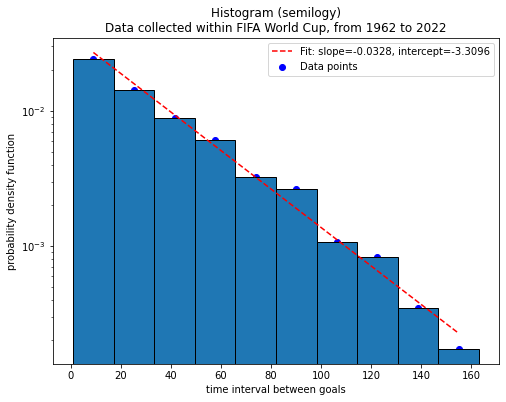

In [227]:
# plot hist
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
n_bins = 10 # using n_bins is better than setting bin edges
counts, edges, patches = plt.hist(goal_time_interval_new, bins=n_bins, edgecolor='black', density=True)

# fit
centers = (edges[:-1] + edges[1:]) / 2
coeffs = np.polyfit(centers, np.log(counts), 1)
slope = coeffs[0]
intercept = coeffs[1]

# plot fit
poly = np.poly1d(coeffs)
y_fit = np.exp(poly(centers))
plt.plot(centers, y_fit, 'r--', label=f'Fit: slope={slope:.4f}, intercept={intercept:.4f}')

# plot dots
plt.scatter(centers, counts, color='blue', label='Data points')

# semilogy
plt.semilogy()

# label, title, legend, ticks
plt.xlabel('time interval between goals')
plt.ylabel('probability density function')
plt.title('Histogram (semilogy)\nData collected within FIFA World Cup, from 1962 to 2022')
plt.legend()
# plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
#            ["0", "10", "20", "30", "40", "50", "60", "70", "80", "90"],
#            rotation = 0)

# save
# plt.savefig("histogram_" + flag + ".jpg")

In [228]:
# check pdf
if sum(counts) * (edges[1] - edges[0]) == 1:
    print("The integral of pdf == 1")
    print("Checking succeeds")
else:
    print("The integral of pdf != 1")
    print("Checking fails")

The integral of pdf == 1
Checking succeeds


In [229]:
# compare lambda
lambda_method_1 = -coeffs[0]
print("lambda (method 1): ", lambda_method_1)
lambda_method_3 = np.e ** coeffs[1]
print("lambda (method 2): ", lambda_method_3)
lambda_method_3 = 1 / np.mean(goal_time_interval_new)
print("lambda (method 3): ", lambda_method_3)

lambda (method 1):  0.03282536911577918
lambda (method 2):  0.03652923993930035
lambda (method 3):  0.03024908518063267


In [230]:
# performance of fit
ss_res = np.sum((counts - y_fit)**2)
ss_tot = np.sum((counts - np.mean(counts))**2)
r2 = 1 - (ss_res / ss_tot)
print("R-squared: {:.8f}".format(r2))

# mse = np.mean((counts - y_fit)**2)
# rmse = np.sqrt(mse)
# print("Mean Squared Error: {:.4f}".format(mse))
# print("Root Mean Squared Error: {:.4f}".format(rmse))

R-squared: 0.97616972
